In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.quantization
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
torch.manual_seed(29592) # for reproducibility

In [ ]:
# Load datasets without headers
train_df = pd.read_csv(
    'https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv',
    sep='\t',
    header=None,
    names=["sentence", "label"]
)

test_df = pd.read_csv(
    'https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv',
    sep='\t',
    header=None,
    names=["sentence", "label"]
)


# Split training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['sentence'], train_df['label'], test_size=0.2, random_state=42
)


In [ ]:
# Ensure all text data is in string format
train_texts = train_texts.astype(str)
val_texts = val_texts.astype(str)
test_sentences = test_df['sentence'].astype(str)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_texts).toarray()
X_val = vectorizer.transform(val_texts).toarray()
X_test = vectorizer.transform(test_sentences).toarray()

y_train = train_labels.values
y_val = val_labels.values
y_test = test_df["label"].values


In [ ]:
# Create custom dataset
class prepareDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Instantiate datasets and dataloaders
train_dataset = prepareDataset(X_train, y_train)
val_dataset = prepareDataset(X_val, y_val)
test_dataset = prepareDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Model Construction

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(10000, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
model = MLP()

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model)}")


Trainable parameters: 5293122


## Model Training

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)

Epoch 1, Val Accuracy: 79.12%
Epoch 2, Val Accuracy: 79.70%
Epoch 3, Val Accuracy: 78.97%
Epoch 4, Val Accuracy: 79.34%
Epoch 5, Val Accuracy: 78.47%
Epoch 6, Val Accuracy: 78.68%
Epoch 7, Val Accuracy: 78.32%
Epoch 8, Val Accuracy: 78.25%
Epoch 9, Val Accuracy: 78.11%
Epoch 10, Val Accuracy: 78.11%


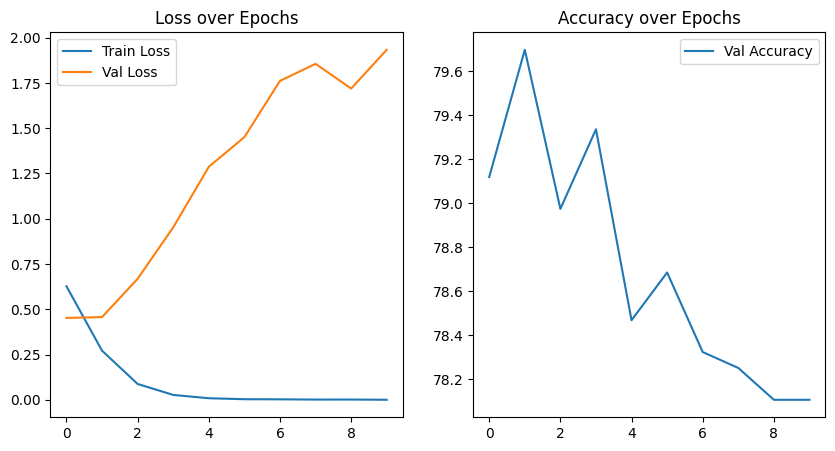

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
best_val_acc = 0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Val Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoint.pt")

# Plotting
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

## Utility functions for calculating model size, latency and accuracy

In [ ]:
# Measure size
def get_model_size(model, label=""):
  torch.save(model.state_dict(), "temp.p")
  size = os.path.getsize("temp.p")
  print("model : ", label, ' \t', 'Size (KB):', size/1e3)
  os.remove('temp.p')
  return size

# Measure Latency
def measure_latency(model, inputs, iterations=100, use_half=False):
    model.eval()
    if use_half:
      inputs = inputs.half()
    start_time = time.time()
    for _ in range(iterations):
        with torch.no_grad():
            model(inputs)
    end_time = time.time()
    avg_time = (end_time - start_time) / iterations
    return avg_time

# Measure accuracy function
def calculate_accuracy(model, dataloader, use_half=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            if use_half:
              inputs = inputs.half()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
print(next(model.parameters()).dtype)

torch.float32


In [ ]:
sample_input = torch.randn(1, 10000).to(device)

## Base Model

In [ ]:
print("original model is : ", model)

original model is :  MLP(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# Measuring base model size
base_model_size = get_model_size(model, "base(fp32)")

# Measure latency for base model
latency_base = measure_latency(model, sample_input)
print(f"Base(fp32) Model Latency : {latency_base * 1000:.6f} ms")

# Calculate accuracy for the dynamic quantized model
accuracy_base = calculate_accuracy(model, test_loader)
print(f"Accuracy of base(fp32) model on test data: {accuracy_base:.2f}%")

model :  base(fp32)  	 Size (KB): 21175.758
Base(fp32) Model Latency : 2.378950 ms
Accuracy of base(fp32) model on test data: 77.76%


## Dynamic Quantization

In [ ]:
dynamic_quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype = torch.qint8
)
print("Dynamic quantized models is : ", dynamic_quantized_model)

Dynamic quantized models is :  MLP(
  (model): Sequential(
    (0): DynamicQuantizedLinear(in_features=10000, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): DynamicQuantizedLinear(in_features=512, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): DynamicQuantizedLinear(in_features=256, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): DynamicQuantizedLinear(in_features=128, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): DynamicQuantizedLinear(in_features=64, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
)


In [ ]:
# Measuring dynamic quantized model size
dynamic_quantized_model_size = get_model_size(dynamic_quantized_model, "int8")
print("{0:.2f} time smaller".format(base_model_size/dynamic_quantized_model_size))

# Measure latency for dynamic quantized model (INT8)
latency_dynamic_quantized = measure_latency(dynamic_quantized_model, sample_input)
print(f"Dynamic Quantized Model Latency (INT8): {latency_dynamic_quantized * 1000:.6f} ms")

# Calculate accuracy for the dynamic quantized model
accuracy_int8 = calculate_accuracy(dynamic_quantized_model, test_loader)
print(f"Accuracy of INT8 (dynamic quantized) model on test data: {accuracy_int8:.2f}%")

model :  int8  	 Size (KB): 5302.482
3.99 time smaller
Dynamic Quantized Model Latency (INT8): 1.012747 ms
Accuracy of INT8 (dynamic quantized) model on test data: 77.81%


## Half Precision

In [ ]:
# Half Precision (FP16)
half_precision_model = model.half()
print(f"Half precision model: {half_precision_model}")


Half precision model: MLP(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# Measuring half-precision model size
half_precision_model_size = get_model_size(half_precision_model, "fp16")
print(f"{base_model_size / half_precision_model_size:.2f} times smaller")

# Measure latency for half-precision (FP16) model
latency_fp16 = measure_latency(half_precision_model, sample_input, use_half = True)
print(f"FP16 Model Latency: {latency_fp16 * 1000:.6f} ms")

# Calculate accuracy for the FP16 model
accuracy_fp16 = calculate_accuracy(half_precision_model, test_loader, use_half=True)
print(f"Accuracy of FP16 model on test data: {accuracy_fp16:.2f}%")

model :  fp16  	 Size (KB): 10589.518
2.00 times smaller
FP16 Model Latency: 1.922121 ms
Accuracy of FP16 model on test data: 77.76%


In [ ]:
print("\n{:<5} {:<15} {:<25} {:<20} {:<20}".format("S.I.", "Model Name", "Accuracy (Out of 100)", "Storage (In MB)", "Inference Time (ms)"))
print("{:<5} {:<15} {:<25.2f} {:<20.2f} {:<20.4f}".format(1, "Original (FP32)", accuracy_base, base_model_size / 1e6, latency_base * 1000))
print("{:<5} {:<15} {:<25.2f} {:<20.2f} {:<20.4f}".format(2, "Dynamic (INT8)", accuracy_int8, dynamic_quantized_model_size / 1e6, latency_dynamic_quantized * 1000))
print("{:<5} {:<15} {:<25.2f} {:<20.2f} {:<20.4f}".format(3, "Half (FP16)", accuracy_fp16, half_precision_model_size / 1e6, latency_fp16 * 1000))



S.I.  Model Name      Accuracy (Out of 100)     Storage (In MB)      Inference Time (ms) 
1     Original (FP32) 77.76                     21.18                2.3790              
2     Dynamic (INT8)  77.81                     5.30                 1.0127              
3     Half (FP16)     77.76                     10.59                1.9221              
